# Import Library

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
filenames = os.listdir("C:/Users/tapas/Downloads/Fire/Training")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'fire':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,fire_0001.jpg,1
1,fire_0002.jpg,1
2,fire_0003.jpg,1
3,fire_0004.jpg,1
4,fire_0005.jpg,1


In [5]:
df.tail()

,filename,category
1828,nofire_334 (95).jpg,0
1829,nofire_334 (96).jpg,0
1830,nofire_334 (97).jpg,0
1831,nofire_334 (98).jpg,0
1832,nofire_334 (99).jpg,0


### See Total In count

<AxesSubplot:>

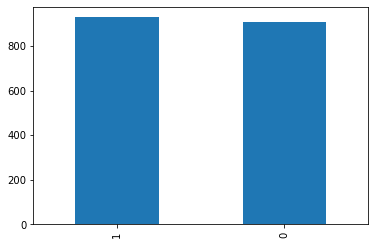

In [6]:
df['category'].value_counts().plot.bar()

In [7]:
df['category'].value_counts()

1    928
0    905
Name: category, dtype: int64

From our data we have 928 'Fire' and 905 'Nofire'

# See sample image

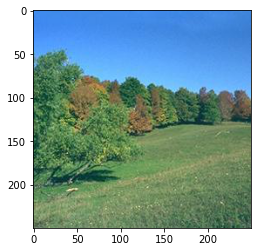

In [8]:
sample = random.choice(filenames)
image = load_img("C:/Users/tapas/Downloads/Fire/Training/"+sample)
plt.imshow(image)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [10]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [11]:
df["category"] = df["category"].replace({0: 'NoFire', 1: 'Fire'}) 

In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

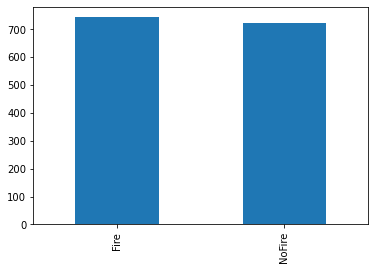

In [13]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

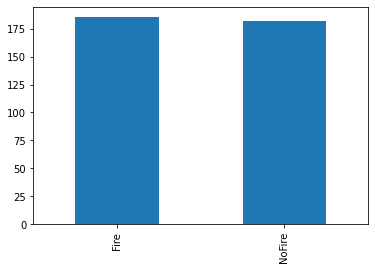

In [14]:
validate_df['category'].value_counts().plot.bar()

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/tapas/Downloads/Fire/Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1465 validated image filenames belonging to 2 classes.


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


### Validation Generator

In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/tapas/Downloads/Fire/Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 367 validated image filenames belonging to 2 classes.


# See how our generator work

In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/tapas/Downloads/Fire/Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


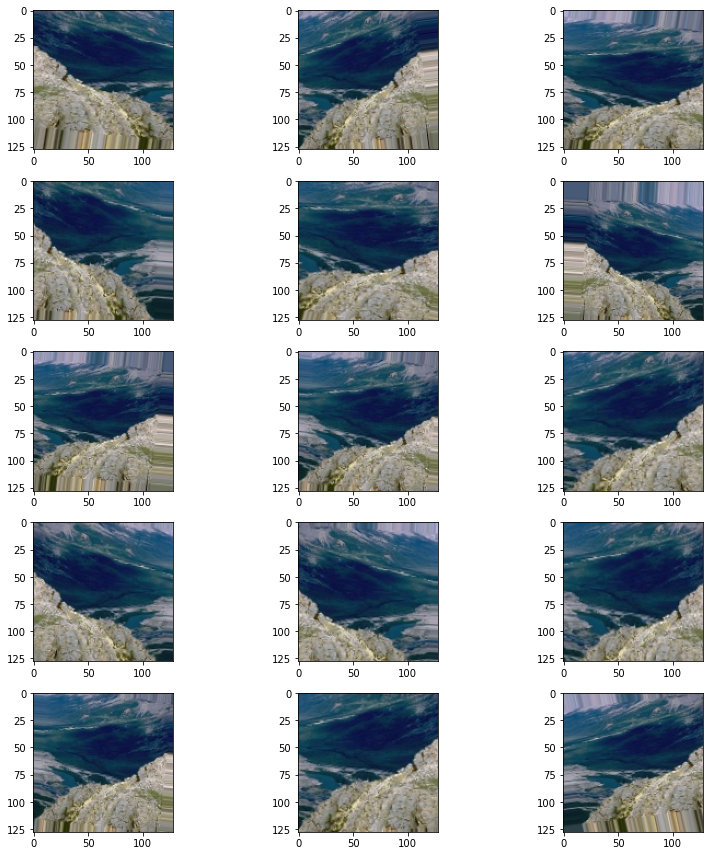

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [20]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50
97/97 [==============================] - 65s 652ms/step - loss: 0.4135 - accuracy: 0.8841 - val_loss: 1.2322 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 2/50
97/97 [==============================] - 58s 601ms/step - loss: 0.3783 - accuracy: 0.8848 - val_loss: 1.4283 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
97/97 [==============================] - 56s 576ms/step - loss: 0.2296 - accuracy: 0.9234 - val_loss: 0.6996 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 4/50
97/97 [==============================] - 56s 579ms/step - loss: 0.2219 - accuracy: 0.9166 - val_loss: 0.1247 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/50
97/97 [==============================] - 65s 674ms/step - loss: 0.1823 - accuracy: 0.9297 - val_loss: 0.1326 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 6/50
97/97 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9441
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 [==============================] - 60s 615ms

# Visualize Training

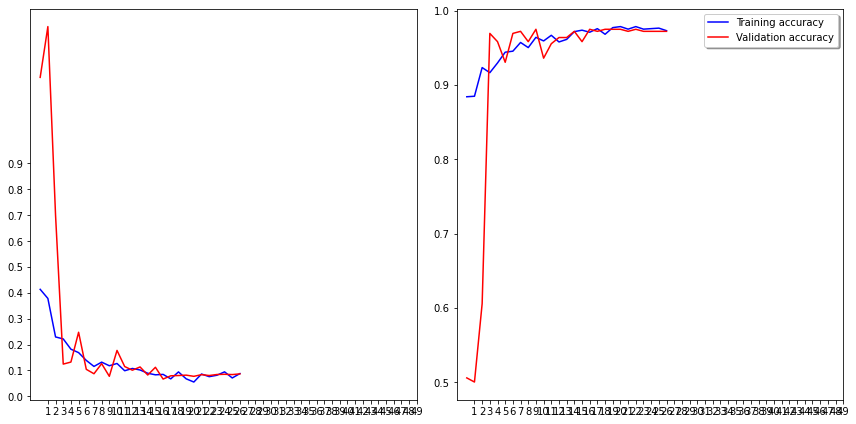

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(10):
    all_test_images = os.listdir("C:/Users/tapas/Downloads/Fire/test")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'C:/Users/tapas/Downloads/Fire/test/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['NoFire','Fire'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 157ms/step
Fire
